# Introduction

In this project we will use straightforward application of multilayered long short-term memory (LSTM) architecture with attention-mechanism to map the input sequence to a vector of a fixed dimensionality, and then another LSTM to decode the target sequence from the vector. Our main focus will be on an English to Roman Urdu translation.

# Data Preprocessing

Import basic libraries.

In [1]:
import os, sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Set basic parameters.

In [2]:
BATCHSIZE = 10
EPOCH = 100
LATENT_DIM = 500
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 1000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

Store data from textfile to usable arrays.

In [3]:
eng = []
man = []
man_inputs = []
count = 0

# preprocess the translation file
for line in open('romanu.txt', 'r', encoding='utf-8'):
    if '\t' not in line:
        continue
    
    count += 1
    if (count > SAMPLES):
        break
    
    # split original and translation into lists
    e, m, _ = line.rstrip().split('\t')
    eng.append(e)
    man.append(m + ' <eos>')
    man_inputs.append('<sos> ' + m)
    
    if (count % 100 == 0):
        print ('Sample Count: {}.'.format(count))

Sample Count: 100.
Sample Count: 200.
Sample Count: 300.
Sample Count: 400.
Sample Count: 500.
Sample Count: 600.
Sample Count: 700.
Sample Count: 800.
Sample Count: 900.


In [4]:
engT = []
manT = []
man_inputsT = []
count = 0

# preprocess the translation file
for line in open('roman_train.txt', 'r', encoding='utf-8'):
    if '\t' not in line:
        continue
    
    count += 1
    if (count > SAMPLES):
        break
    
    # split original and translation into lists
    eT, mT, _ = line.rstrip().split('\t')
    engT.append(eT)
    manT.append(mT + ' <eos>')
    man_inputsT.append('<sos> ' + mT)
    
    if (count % 100 == 0):
        print ('Sample Count: {}.'.format(count))

Sample Count: 100.
Sample Count: 200.
Sample Count: 300.


Tokenize the input and output sentences, and create maps that can be used by the network.

In [5]:
#train data tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenize input and generate idx map
tok_in = Tokenizer(num_words=MAX_WORD_NUM)
tok_in.fit_on_texts(eng)
eng_seq = tok_in.texts_to_sequences(eng)
word2idx_in = tok_in.word_index
max_in_len = max(len(s) for s in eng_seq)

print("Number of input tokens: {}".format(len(word2idx_in)))
print("Maximum input sequence length: {}".format(max_in_len))

# tokenize output and generate idx map
tok_out = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tok_out.fit_on_texts(man + man_inputs)
man_seq = tok_out.texts_to_sequences(man)
man_seq_inputs = tok_out.texts_to_sequences(man_inputs)
word2idx_out = tok_out.word_index
max_out_len = max(len(s) for s in man_seq)
out_word_num = len(word2idx_out) + 1

print("Number of output tokens: {}".format(len(word2idx_out)))
print("Maximum output sequence length: {}".format(max_out_len))

Number of input tokens: 1185
Maximum input sequence length: 17
Number of output tokens: 1485
Maximum output sequence length: 20


In [6]:
#test data tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenize input and generate idx map
tok_inT = Tokenizer(num_words=MAX_WORD_NUM)
tok_inT.fit_on_texts(engT)
eng_seqT = tok_inT.texts_to_sequences(engT)
word2idx_inT = tok_inT.word_index
max_in_lenT = max(len(s) for s in eng_seqT)

print("Number of input tokens: {}".format(len(word2idx_inT)))
print("Maximum input sequence length: {}".format(max_in_lenT))

# tokenize output and generate idx map
tok_outT = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tok_outT.fit_on_texts(manT + man_inputsT)
man_seqT = tok_out.texts_to_sequences(manT)
man_seq_inputsT = tok_outT.texts_to_sequences(man_inputsT)
word2idx_outT = tok_outT.word_index
max_out_lenT = max(len(s) for s in man_seqT)
out_word_numT = len(word2idx_outT) + 1

print("Number of output tokens: {}".format(len(word2idx_outT)))
print("Maximum output sequence length: {}".format(max_out_lenT))

Number of input tokens: 538
Maximum input sequence length: 8
Number of output tokens: 671
Maximum output sequence length: 15


Pad the input and output sequences to be the same length.

In [7]:
from keras.preprocessing.sequence import pad_sequences

eng_seq_padded = pad_sequences(eng_seq, maxlen=max_in_len)
man_seq_padded = pad_sequences(man_seq, maxlen=max_out_len, padding='post')
man_seq_inputs_padded = pad_sequences(man_seq_inputs, maxlen=max_out_len, padding='post')

In [8]:
#padding for test dataset
from keras.preprocessing.sequence import pad_sequences

eng_seq_paddedT = pad_sequences(eng_seqT, maxlen=max_in_len)
man_seq_paddedT = pad_sequences(man_seqT, maxlen=max_out_len, padding='post')
man_seq_inputs_paddedT = pad_sequences(man_seq_inputsT, maxlen=max_out_len, padding='post')

Load in word2vec word vectors and use them to create word embeddings. [The dataset](https://github.com/alexandres/lexvec#pre-trained-vectors) from this link

In [10]:
wordVec = {}

print('Loading wordVec')
import io

fin = io.open('lexvec.enwiki+newscrawl.300d.W.pos.vectors', 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(lambda x: (str, int)[x.isdigit() or x.strip("-").isdigit()](x), fin.readline().split())
data = {}
for line in fin:
    tokens = line.rstrip().split(' ')
    data[tokens[0]] = map(float, tokens[1:])
print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [11]:
wordNum = min(MAX_WORD_NUM, len(word2idx_in) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

# create word embedding by fetching each word vector
for tok, idx in word2idx_in.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

Create translated target matrix by loading the padded output target sequence using one-hot encoding.

In [12]:
man_target_one_hot = np.zeros((len(eng), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(man_seq_padded):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

# Model Definition

Create the encoder and decoder before attention.

In [13]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import keras.backend as K
from keras.models import Model

# Embedding
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

# Encoder
input_layer_encoder = Input(shape=(max_in_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(out_word_num, EMBEDDING)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LATENT_DIM_DECODER, return_state=True)
dense_decode = Dense(out_word_num, activation='softmax')
s0 = Input(shape=(LATENT_DIM_DECODER,))
c0 = Input(shape=(LATENT_DIM_DECODER,))

Implementation of Attention. 


In [14]:
# Dimension of x is N x T x D.
def softmax(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# Some of the common layers for attention
repeat_attn = RepeatVector(max_in_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')  # over time dimension T
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      # over time dimension T

def iterAttn(h, prevOut):
    """
    h: encoder encoded hidden states at all time.
    prevOut: output at the previous time (word).
    An iteration of attention.
    """
    prevOutRepeat = repeat_attn(prevOut) # Tx, LATENT_DIM_DECODE
    total = concat_attn([h, prevOutRepeat]) # Tx, LATENT_DIM_DECODE + LATENT_DIM * 2
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])
    
    return context

Execute encoder-decoder and attention.

In [18]:
s = s0
c = c0

# Iterate attention Ty times
all_out = []
for t in range(max_out_len):
    # Get context vector with encoder and attention
    context = iterAttn(encoder_out, s) 
    
    # For teacher forcing, get the previous word
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)
    
    # Concat context and previous word as decoder input
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])
    
    # pass into decoder, inference output
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)

The output needs to be stacked to be considered as the network's output. 

In [19]:
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [20]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

# Model Training

First, define customized loss and accuracy metrics for training.

In [21]:
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32') # filter out padding value 0.
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

Train model using Adam optimizer and defined loss and metrics. 

In [22]:
attnModel.compile(optimizer='Adam', loss=myLoss, metrics=[acc])

# Define empty s0 and c0
init_s = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))
init_c = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))

print(BATCHSIZE)

# Train
history = attnModel.fit(
    x=[eng_seq_padded, man_seq_padded, init_s, init_c],
    y=man_target_one_hot,
    batch_size=BATCHSIZE,
    epochs=EPOCH,
    validation_split=0.22
)

10
Epoch 1/100
71/71 [==============================] - 136s 727ms/step - loss: 6.2666 - acc: 0.1279 - val_loss: 5.7645 - val_acc: 0.1100
Epoch 2/100
71/71 [==============================] - 31s 435ms/step - loss: 5.0491 - acc: 0.1775 - val_loss: 6.0137 - val_acc: 0.1181
Epoch 3/100
71/71 [==============================] - 31s 434ms/step - loss: 4.8609 - acc: 0.1846 - val_loss: 5.9717 - val_acc: 0.1169
Epoch 4/100
71/71 [==============================] - 31s 437ms/step - loss: 4.7220 - acc: 0.1885 - val_loss: 6.0979 - val_acc: 0.1266
Epoch 5/100
71/71 [==============================] - 31s 443ms/step - loss: 4.5405 - acc: 0.1924 - val_loss: 6.2605 - val_acc: 0.1274
Epoch 6/100
71/71 [==============================] - 31s 439ms/step - loss: 4.4607 - acc: 0.1952 - val_loss: 6.4584 - val_acc: 0.1236
Epoch 7/100
71/71 [==============================] - 32s 446ms/step - loss: 4.3143 - acc: 0.2054 - val_loss: 6.4478 - val_acc: 0.1291
Epoch 8/100
71/71 [==============================] - 31s 4

Plot training history.

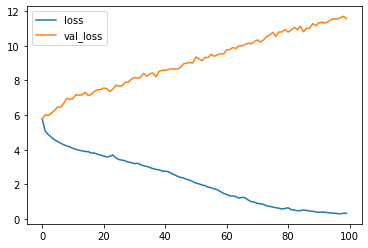

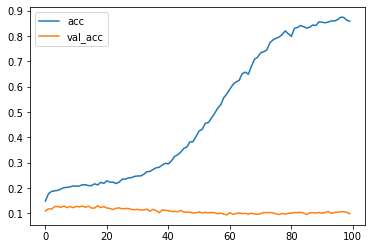

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [24]:
attnModel.save('attention_model_35_man.h5')

# Testing Model

Since in the inference model teacher forcing is not available, thus the model needs to be modified to use the previous inference result.

In [25]:
# Encoder
encoder_inf = Model(input_layer_encoder, encoder_out)
encoder_out_inf = Input(shape=(max_in_len, LATENT_DIM * 2,))

# Decoder
decoder_in_inf = Input(shape=(1,))
decoder_in_embed_inf = embed_decoder(decoder_in_inf)

# Context, concat without teacher forcing.
context_inf = iterAttn(encoder_out_inf, s0)
decoder_in_concat_inf = concat2([context_inf, decoder_in_embed_inf])

# Decoder inference
pred, s, c = decoder(decoder_in_concat_inf, initial_state=[s0, c0])
pred_out = dense_decode(pred)

# Define model
decoder_inf = Model(
    inputs=[decoder_in_inf, encoder_out_inf, s0, c0],
    outputs=[pred_out, s, c]
)

Reverse the word-to-index maps to convert translated indices to words. Then use the inference encoder and decoder models to create predictions.

In [26]:
idx2word_in = {b:a for a, b in word2idx_inT.items()}
idx2word_out = {b:a for a, b in word2idx_outT.items()}

def inference(eng_seq):
    # Encode
    encoder_output = encoder_inf.predict(eng_seq)
    
    # Create output seq matrix
    target_output = np.zeros((1, 1))
    target_output[0, 0] = word2idx_outT['<sos>']
    
    # init
    eos = word2idx_outT['<eos>']
    s0 = np.zeros((1, LATENT_DIM_DECODER))
    c0 = np.zeros((1, LATENT_DIM_DECODER))
    
    output_seq = []
    s = s0
    c = c0
    for _ in range(max_out_len):
        # Decoder inference
        pred, s, c = decoder_inf.predict([target_output, encoder_output, s, c])
        
        # update output seq
        tok = np.argmax(pred.flatten())
        if tok == eos:
            break
        if tok > 0:
            word = idx2word_out[tok]
            output_seq.append(word)

        # Update decoder input
        target_output[0, 0] = tok
        
    sentence = ' '.join(output_seq)
    return sentence

Observe some of the sample inference results:

In [27]:
test_actual_sentence=[]
test_predicted_sentence=[]
for _ in range(5):
    i = np.random.choice(len(engT))
    eng_sen = eng_seq_paddedT[i:i+1]
    man_pred = inference(eng_sen)

    print('--------------------------------------')
    print('English: {}'.format(engT[i]))
    print('Prediction: {}'.format(man_pred))
    print('acutual truth: {}'.format(manT[i])) 
    test_actual_sentence.append(engT[i])
    test_predicted_sentence.append(man_pred)

--------------------------------------
English: You can go wherever you want.
Prediction: mujhe logon ko hon. mein
acutual truth: tum jahan jana chaho ja satke ho. <eos>
--------------------------------------
English: Please speak more loudly.
Prediction: hai yeh satke theek farigh
acutual truth: braay meharbani thora ouncha bolay. <eos>
--------------------------------------
English: I don't know her.
Prediction: raha ne apni taqreeban bharr
acutual truth: mein uss ( larki ) ko nahi jaanta. <eos>
--------------------------------------
English: I am older than your brother.
Prediction: is nahi shukriya nahi woh ki.
acutual truth: mein tumahray bhai se bara hon. <eos>
--------------------------------------
English: This is too big.
Prediction: kab aaya. ka ka tum hai. tum ko
acutual truth: yeh bohat bara hai. <eos>


# Conclusion

This project implements an seq2seq model using LSTM and attention mechanism. It is observed that the model achieves an accuracy of 0.90 on validation data, although some of the translated sentences differ from the actual output to some extent but overall they look fine.


In [28]:
import nltk
pred=[]
for words in test_predicted_sentence:
    pred.append(words.split())

In [29]:
actual=[]
for words in test_actual_sentence:
    actual.append(words.split())

In [30]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
BLEUscore = nltk.translate.bleu_score.corpus_bleu(actual,pred,smoothing_function=chencherry.method4)
print(BLEUscore)

0


In [31]:
import sacrebleu
x=sacrebleu.raw_corpus_bleu(test_predicted_sentence,[test_actual_sentence])
print(x)

BLEU = 0.48 0.3/0.4/0.5/0.7 (BP = 1.000 ratio = 1.208 hyp_len = 29 ref_len = 24)
